# MODERN VAE

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import v2
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
from comet_ml import Experiment
import os
import torch.nn.functional as F

## PREPARE MNIST DATA

In [2]:
batch_size = 128
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    # v2.Lambda(lambda x: x.view(-1) - 0.5),
    v2.Lambda(lambda x: x.view(-1))
])

# Download and load the training data
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
# Download and load the test data
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform,
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

## Modern VAE

In [3]:
class VAEModern(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAEModern, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, 2 * latent_dim), # 2 * for mean and variance
        )
        self.softplus = nn.Softplus()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )
        
    def encode(self, x, eps = 1e-8):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability - avoid /0 or log(0)
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1) # torch.chunk - Attempts to split a tensor into the specified number of chunks. Each chunk is a view of the input tensor.

        # logvar can be <0 we dont want that 
        # self.softplus(logvar) works like log(1 + exp(logvar)) so that scale is always > 0
        scale = self.softplus(logvar) + eps

        # changes scale size from [batch_size, latent_dim] -> [batch_size, latent_dim, latent_dim] (makes it a diagonal matrix)
        scale_tril = torch.diag_embed(scale)
        
        # Multidimentional Normal Distribution with avg mu and covariance matrix scale_tril
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)

    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.
        
        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        # rsample (reparametrized sample) is just z = mu + scale * ε 
        # keeps the computation graph intact and enables backpropagation
        return dist.rsample()
    
    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)

    def forward(self, x):
        """
            Performs a forward pass of the VAE.
        Args:
            x (torch.Tensor): Input data.
        
        Returns:
            reconstructed_x: Reconstructed input data.
        """

        distribution = self.encode(x)
        z = self.reparameterize(distribution)
        reconstructed_x = self.decode(z)

        return distribution, z, reconstructed_x 

### LOSS FUNCTION

In [4]:
def loss_fn(x, x_reconstructed, distribution, z, loss_type):
    if loss_type == "BCE":
        # Reconstruction Loss
        loss_reconstruction = F.binary_cross_entropy(x_reconstructed, x, reduction='none').sum(-1).mean()

        # KL Divergence
        # Normal distribution N(0,1) with size like distribution from encode()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_KL = torch.distributions.kl.kl_divergence(distribution, std_normal).mean()
    elif loss_type == "MSE":
        pass

    loss = loss_reconstruction + loss_KL
    return loss, loss_reconstruction, loss_KL

## MODEL PARAMETERS

In [5]:
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 10
latent_dim = 2
hidden_dim = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAEModern(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [6]:
print(model)

VAEModern(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): SiLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): SiLU()
    (8): Linear(in_features=512, out_features=784, bias=True)
    (9): Sigmoid()
  )
)


## COMET ML SETUP

In [7]:
# Initialize Comet.ml experiment
experiment = Experiment(
    api_key=os.getenv("COMET_API_KEY"),
    project_name="Lo-Fi generator",
)

experiment.set_name("VAE Modern bigger")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ziemmi13/lo-fi-generator/851f1aa137c941a6b0fe9c16609a1d44



COMET INFO: Couldn't find a Git repository in 'c:\\Users\\Hyperbook\\Desktop\\STUDIA\\SEM III\\Projekt zespołowy' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


## TRAINING

In [8]:
def train(device, model, train_loader, val_loader, optimizer, num_epochs, scheduler, resume_path=None, early_stopping_patience=5):
    model.to(device)

    for epoch in range(num_epochs):
        #Training phase
        model.train()
        train_loss = 0
        train_loss_reconstruction = 0
        train_loss_KL = 0
        for batch_idx, batch in enumerate(train_loader):
            images, _ = batch
            images = images.to(device)
            optimizer.zero_grad()
            distribution, z, reconstructed_images  = model(images)
            loss, loss_reconstruction, loss_KL = loss_fn(images, reconstructed_images, distribution, z, loss_type="BCE")
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_loss_reconstruction += loss_reconstruction.item()
            train_loss_KL += loss_KL.item()

            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch + 1}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
                experiment.log_metric("train_loss", loss.item(), step=epoch * len(train_loader) + batch_idx)
                experiment.log_metric("train_loss_reconstruction", loss_reconstruction.item(), step=epoch * len(train_loader) + batch_idx)
                experiment.log_metric("train_loss_KL", loss_KL.item(), step=epoch * len(train_loader) + batch_idx)

        epoch_loss = train_loss / len(train_loader)
        epoch_reconstruction_loss = train_loss_reconstruction / len(train_loader)
        epoch_KL = train_loss_KL / len(train_loader)
        # Log epoch metrics
        experiment.log_metric("epoch_train_loss", epoch_loss, step=epoch)
        experiment.log_metric("epoch_train_loss_reconstruction", epoch_reconstruction_loss, step=epoch)
        experiment.log_metric("epoch_train_loss_KL", epoch_KL, step=epoch)

        # Validation phase
        if val_loader:
            model.eval()
            val_loss = 0
            val_loss_reconstruction = 0
            val_loss_KL = 0
            with torch.no_grad():
                for batch_idx, batch in enumerate(val_loader):
                    images, _ = batch
                    images = images.to(device)
                    distribution, z, reconstructed_images  = model(images)
                    loss, loss_reconstruction, loss_KL = loss_fn(images, reconstructed_images, distribution, z, loss_type="BCE")
                    val_loss += loss.item()
                    val_loss_reconstruction += loss_reconstruction.item()
                    val_loss_KL += loss_KL.item()

            val_epoch_loss = val_loss / len(val_loader) 
            val_epoch_reconstruction_loss = val_loss_reconstruction / len(val_loader)
            val_epoch_KL = val_loss_KL / len(val_loader)
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]')
            print(f'Training Loss: {epoch_loss:.4f}')
            print(f'Validation Loss: {val_epoch_loss:.4f}')
            print('-' * 60)

            # Log validation metrics
            experiment.log_metric("val_loss", val_epoch_loss, step=epoch)
            experiment.log_metric("epoch_val_loss_reconstruction", val_epoch_reconstruction_loss, step=epoch)
            experiment.log_metric("epoch_val_loss_KL", val_epoch_KL, step=epoch)


In [9]:
train(device=device, model=model, train_loader=train_loader, val_loader=None, optimizer=optimizer, num_epochs=20, scheduler=None)

Epoch: 1, Batch: 0, Loss: 543.9001
Epoch: 1, Batch: 100, Loss: 189.9000
Epoch: 1, Batch: 200, Loss: 183.7066
Epoch: 1, Batch: 300, Loss: 194.8102
Epoch: 1, Batch: 400, Loss: 177.7199
Epoch: 2, Batch: 0, Loss: 173.7579
Epoch: 2, Batch: 100, Loss: 167.1983
Epoch: 2, Batch: 200, Loss: 168.6615
Epoch: 2, Batch: 300, Loss: 160.4153
Epoch: 2, Batch: 400, Loss: 156.9176
Epoch: 3, Batch: 0, Loss: 155.4228
Epoch: 3, Batch: 100, Loss: 159.7557
Epoch: 3, Batch: 200, Loss: 148.5857
Epoch: 3, Batch: 300, Loss: 152.8024
Epoch: 3, Batch: 400, Loss: 151.5106
Epoch: 4, Batch: 0, Loss: 150.7074
Epoch: 4, Batch: 100, Loss: 151.4945
Epoch: 4, Batch: 200, Loss: 150.6387
Epoch: 4, Batch: 300, Loss: 147.4597
Epoch: 4, Batch: 400, Loss: 150.6450
Epoch: 5, Batch: 0, Loss: 136.0916
Epoch: 5, Batch: 100, Loss: 141.7434
Epoch: 5, Batch: 200, Loss: 149.9010
Epoch: 5, Batch: 300, Loss: 144.3490
Epoch: 5, Batch: 400, Loss: 143.2630
Epoch: 6, Batch: 0, Loss: 140.7795
Epoch: 6, Batch: 100, Loss: 146.0118
Epoch: 6, Bat

## END EXPERIMENT

In [10]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : VAE Modern bigger
COMET INFO:     url                   : https://www.comet.com/ziemmi13/lo-fi-generator/851f1aa137c941a6b0fe9c16609a1d44
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch_train_loss [20]                : (137.03654657294754, 197.81769885488157)
COMET INFO:     epoch_train_loss_KL [20]             : (2.584062655724442, 6.807474919219516)
COMET INFO:     epoch_train_loss_reconstruction [20] : (130.22907159475884, 195.2336356482272)
COMET INFO:     train_loss [100]                     : (130.29330444335938, 543.900146484375)
COMET INFO:     train_loss_KL [100]                  : (0.21414725482463837, 6.996251583099365)
COM

## Latent space

In [11]:
def plot_latent(model, data_loader, num_batches=100):
    model.eval() 
    plt.figure(figsize=(8, 6))

    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            x = x.to(device)
            
            distribution, z, reconstructed_x = model(x)
            
            z = z.cpu().numpy()
            y = y.numpy()

            if z.shape[1] >= 2:  # Check if latent dim >= 2
                plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10', alpha=0.6, s=10)
            
            if i >= num_batches:
                break

    plt.colorbar()
    plt.title("Latent Space Projection")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.grid(True)
    plt.show()

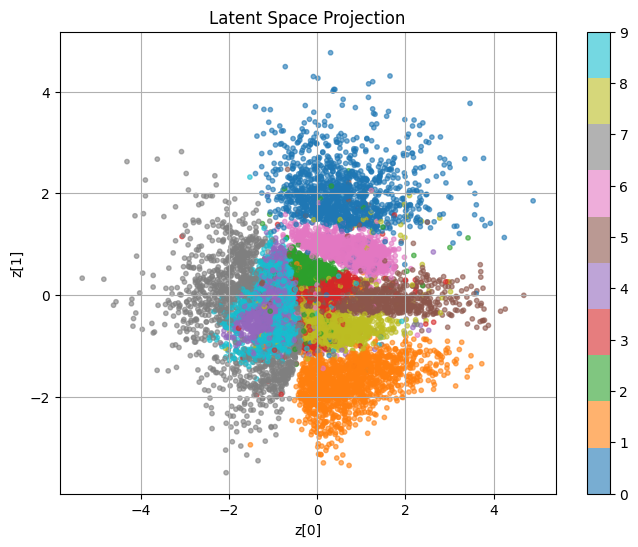

In [12]:
plot_latent(model, train_loader)

## RECONSTRUCTION RESULTS

In [13]:
def plot_reconstructed(model, r0=(-6, 6), r1=(-6, 6), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decode(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])


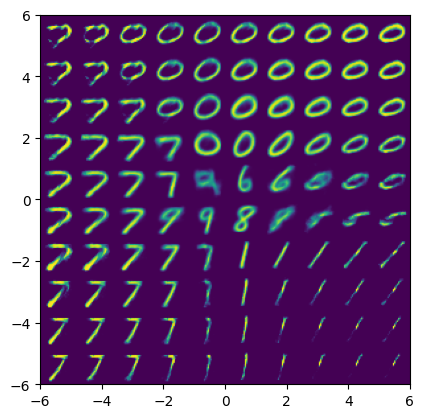

In [22]:
plot_reconstructed(model, r0=(-6, 6), r1=(-6, 6), n=10)

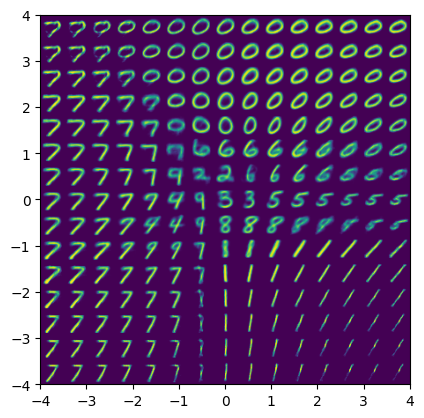

In [23]:
plot_reconstructed(model, r0=(-4, 4), r1=(-4, 4), n=15)

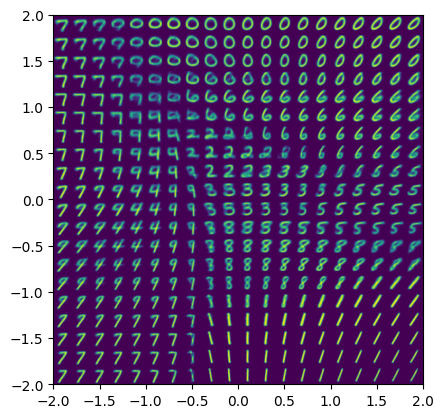

In [24]:
plot_reconstructed(model, r0=(-2, 2), r1=(-2, 2), n=20)

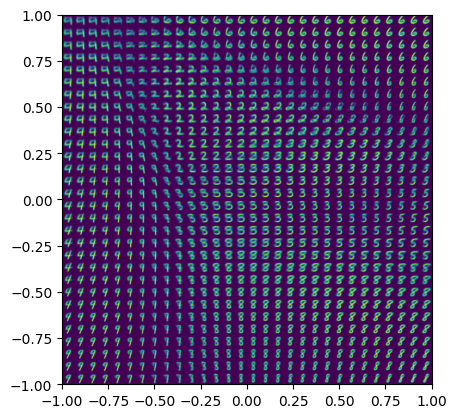

In [26]:
plot_reconstructed(model, r0=(-1, 1), r1=(-1, 1), n=30)